# 3.1 En este notebook analizaremos y aplicaremos transformaciones sobre el set de datos que contiene los registros de causas que NO corresponden a violencia de género (Set de datos II)

In [ ]:
!pip install diffprivlib

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import diffprivlib as dp
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

In [ ]:
###Conecto al drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
###Cargo Dataset 
ds = pd.read_csv('/content/gdrive/MyDrive/dataset_gral.csv', index_col=0)

In [ ]:
ds.shape

(2276, 20)

In [ ]:
ds.head()

,ART_INFRINGIDO,CODIGO_O_LEY,CONDUCTA,CONDUCTA_DESCRIPCION,V_FISICA,MODALIDAD_DE_LA_VIOLENCIA,NACIONALIDAD_ACUSADO/A,EDAD_ACUSADO/A AL MOMENTO DEL HECHO,NIVEL_INSTRUCCION_ACUSADO/A,NACIONALIDAD_DENUNCIANTE,EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO,FRECUENCIA_EPISODIOS,RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE,HIJOS_HIJAS_EN_COMUN,MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO,LUGAR_DEL_HECHO\n,TIPO_DE_RESOLUCION,OBJETO_DE_LA_RESOLUCION,DETALLE,DECISION
NRO_REGISTRO,,,,,,,,,,,,,,,,,,,,
0708,128,codigo_penal_de_la_nacion,mesnna_masnna,no_corresponde,no_corresponde,no_corresponde,s/d,s/d,s/d,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,mediante_medios_tecnológicos,interlocutoria,cuestion_de_competencia,incompetencia_territorial,hace_lugar
0709,NaN,NaN,allanamiento_autonomo,no_corresponde,no_corresponde,no_corresponde,s/d,s/d,s/d,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,en_domicilio_laboral,definitiva,medida_probatoria,allanamiento,no_hace_lugar
0710,NaN,NaN,allanamiento_autonomo,no_corresponde,no_corresponde,no_corresponde,s/d,s/d,NaN,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,en_domicilio_laboral,definitiva,medida_probatoria,allanamiento,no_hace_lugar
0711,54,codigo_contravencional,arrojar_sustancias_insalubres_en_lugares_publicos,no_corresponde,no_corresponde,no_corresponde,argentina,58,universitario_completo,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,en_domicilio_laboral,interlocutoria,medida_cautelar,clausura,no_hace_lugar
0711bis,149bis,codigo_penal_de_la_nacion,amenazas,simples,no_corresponde,no_corresponde,argentina,27,s/d,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,no_corresponde,mediante_medios_tecnológicos,interlocutoria,cuestion_de_competencia,incompetencia_territorial,no_hace_lugar


## 3.1.1 Análisis de features

##### El objetivo del análisis exploratorio en esta etapa es identificar qué columnas tienen información relevante para el negocio (por ejemplo que no contenga muchas valores nulos). Asimismo, se tratará de reducir la dimensionalidad del dataset, ya que el ruido a agregar para garantizar DP aumenta en función de la cantidad de consultas * que realicemos. Por ello, nuestro objetivo en esta etapa es reducir el número de features portadores de información relevante. 

##### Lo que haremos en primer lugar es verificar qué campos contienen cantidades muy elevadas de valores nulos. Esos campos son candidatos para ser eliminados. En segundo lugar, analizaremos la distribucion conjunta de co variables seleccionadas en base al conocimiento del dominio (si analizaramos todas estaríamos en el orden de $2^n$ de distribuciones covariadas, muchas de las cuales no tienen sentido desde la perspectiva del negocio). En base a este análisis, evaluaremoss si es posible combinar dos atributos en uno nuevo.

##### * A los fines de comprensión de la presentación, consideraremos de forma provisoria que estamos haciendo una consulta por cada feature del dataset (un desarrollo en profundidad del tema puede hallarse en el cuerpo de la tesis).

In [ ]:
ds.columns

Index(['ART_INFRINGIDO', 'CODIGO_O_LEY', 'CONDUCTA', 'CONDUCTA_DESCRIPCION',
       'V_FISICA', 'MODALIDAD_DE_LA_VIOLENCIA', 'NACIONALIDAD_ACUSADO/A',
       'EDAD_ACUSADO/A AL MOMENTO DEL HECHO', 'NIVEL_INSTRUCCION_ACUSADO/A',
       'NACIONALIDAD_DENUNCIANTE', 'EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO',
       'FRECUENCIA_EPISODIOS', 'RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE',
       'HIJOS_HIJAS_EN_COMUN',
       'MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO',
       'LUGAR_DEL_HECHO\n', 'TIPO_DE_RESOLUCION', 'OBJETO_DE_LA_RESOLUCION',
       'DETALLE', 'DECISION'],
      dtype='object')

In [ ]:
### Elimino las columnas que refieren SOLO a causas de violencia de género

eliminar = ['V_FISICA','MODALIDAD_DE_LA_VIOLENCIA','NACIONALIDAD_DENUNCIANTE', 'EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO', \
            'FRECUENCIA_EPISODIOS', 'RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE','HIJOS_HIJAS_EN_COMUN', \
            'MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO']
ds.drop(columns=eliminar, inplace=True)

In [ ]:
ds.shape

(2276, 12)

#### Control de valores faltantes

##### Ademas de chequear por valores missing, consideraremos valores faltantes aquellos que tengan la leyenda "no_corresponde" y "s/d". 

In [ ]:
ds.isna().sum()/len(ds)

ART_INFRINGIDO                         0.008787
CODIGO_O_LEY                           0.008787
CONDUCTA                               0.000000
CONDUCTA_DESCRIPCION                   0.000439
NACIONALIDAD_ACUSADO/A                 0.000000
EDAD_ACUSADO/A AL MOMENTO DEL HECHO    0.000000
NIVEL_INSTRUCCION_ACUSADO/A            0.051845
LUGAR_DEL_HECHO\n                      0.000439
TIPO_DE_RESOLUCION                     0.000000
OBJETO_DE_LA_RESOLUCION                0.000000
DETALLE                                0.069859
DECISION                               0.000439
dtype: float64

In [ ]:
ds[ds == 'no_corresponde'].count()/len(ds)

ART_INFRINGIDO                         0.000000
CODIGO_O_LEY                           0.000000
CONDUCTA                               0.000000
CONDUCTA_DESCRIPCION                   0.767575
NACIONALIDAD_ACUSADO/A                 0.054921
EDAD_ACUSADO/A AL MOMENTO DEL HECHO    0.056239
NIVEL_INSTRUCCION_ACUSADO/A            0.055800
LUGAR_DEL_HECHO\n                      0.000439
TIPO_DE_RESOLUCION                     0.000000
OBJETO_DE_LA_RESOLUCION                0.000000
DETALLE                                0.000000
DECISION                               0.000000
dtype: float64

In [ ]:
ds[ds == 's/d'].count()/len(ds)

ART_INFRINGIDO                         0.000000
CODIGO_O_LEY                           0.000000
CONDUCTA                               0.000000
CONDUCTA_DESCRIPCION                   0.000000
NACIONALIDAD_ACUSADO/A                 0.145431
EDAD_ACUSADO/A AL MOMENTO DEL HECHO    0.183656
NIVEL_INSTRUCCION_ACUSADO/A            0.366432
LUGAR_DEL_HECHO\n                      0.032513
TIPO_DE_RESOLUCION                     0.000000
OBJETO_DE_LA_RESOLUCION                0.000000
DETALLE                                0.000000
DECISION                               0.000000
dtype: float64

In [ ]:
(ds.isna().sum() + ds[ds == 'no_corresponde'].count() + ds[ds == 's/d'].count())/len(ds)

ART_INFRINGIDO                         0.008787
CODIGO_O_LEY                           0.008787
CONDUCTA                               0.000000
CONDUCTA_DESCRIPCION                   0.768014
NACIONALIDAD_ACUSADO/A                 0.200351
EDAD_ACUSADO/A AL MOMENTO DEL HECHO    0.239895
NIVEL_INSTRUCCION_ACUSADO/A            0.474077
LUGAR_DEL_HECHO\n                      0.033392
TIPO_DE_RESOLUCION                     0.000000
OBJETO_DE_LA_RESOLUCION                0.000000
DETALLE                                0.069859
DECISION                               0.000439
dtype: float64

##### Vemos que los features CONDUCTA_DESCRIPCION y NIVEL_INSTRUCCION_ACUSADO/A  presentan valores faltantes en una proporción muy elevada, por ello los eliminaremos del análisis posterior.

In [ ]:
ds.drop(['CONDUCTA_DESCRIPCION', 'NIVEL_INSTRUCCION_ACUSADO/A'], axis=1, inplace=True)

#### Análisis de variables correlacionadas y reducción de features

In [ ]:
def freq_coords(ct):
  """
  Esta función sirve para analizar la distribución conjunta de dos variables categóricas.
  Estima la frecuencia para cada par de categorías y devuelve una lista ordenada en base a la frecuencia relativa de cada una

  Parámetros
  ----------
  ct: DataFrame de pandas que representa una tabla de contingencia generada mediante pandas.crosstab(index, columns, margins=True)

  Salida
  ------
  pandas DataFrame:
    Devuelve un DataFrame de pandas que contiene una fila por cada par posible de categorías entre las dos variables. Una columna indica la frecuencia
    absoluta y otra la frecuencia relativa de cada combinación. El índice del DataFrame está ordenado de acuerdo a la frecuencia de mayor a menor.

  """
  cols = ct.columns
  filas = ct.index
  coord = []
  valor = []
  for fila in filas[:-1]:
    for columna in cols[:-1]:
      coord.append(str(fila) + ' / ' + str(columna))
      valor.append(ct.loc[fila, columna])
  frecuencias = pd.DataFrame([coord,valor]).T
  frecuencias.columns = ['Coord.', 'Freq.']
  frecuencias.set_index('Coord.', inplace=True)
  frecuencias.sort_values(by='Freq.', inplace=True, ascending=False)
  frecuencias['% Acum'] = np.cumsum(frecuencias['Freq.'])*100/sum(valor)
  return frecuencias

##### Análisis de distribución conjunta de CODIGO_O_LEY y ART_INFRINGIDO

In [ ]:
ct = pd.crosstab(ds.CODIGO_O_LEY, ds.ART_INFRINGIDO, margins=True)
ct 

ART_INFRINGIDO,1,1.1.6,1.3.3,1.3.31,10.1.5,100,101,103,104,105,106,107,108,109,11.1.10,11.1.2,11.1.4,111,113,114,116,118,120,125bis,128,129,129_parr2,13,131,135,14,148bis,149bis,149bis_parr2,150,153bis,153bis_parr2,162,164,168,17,172,173_inc15,174,181_inc1,183,184_inc5,186,186_inc1,186_inc4,186_inc5,189bis,193bis,2.1.1,2.1.15,2.1.16,2.1.17,2.1.19,2.1.3,2.2.1,2.2.14,205,208,210,23,238,239,248,249,258,266,273,289_inc3,292_parr1,292_parr2,295,296,3,3.1.1,301bis,4.1.1,4.1.1.2,4.1.17,4.1.22,4.1.24,4.1.7,51,52,53bis_inc3,54,56,57,58,59,5c,5d,5e,6,6.1.12,6.1.12.1,6.1.2,6.1.26,6.1.28,6.1.31,6.1.4,6.1.40,6.1.41,6.1.42,6.1.44,6.1.47,6.1.49,6.1.52,6.1.54,6.1.63,6.1.8,6.1.9,6.1.94,65bis,71 quinquíes,71bis,71ter,72,73,74,76,77,79,80,80_inc2,81,82,83,84,85,86,87,88,89,9.1.1,90,92,93,94,94bis,95,96,97,98,penal,All
CODIGO_O_LEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189bis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
codigo_contravencional,0,0,0,0,0,2,3,1,5,0,4,0,1,3,0,0,0,100,2,81,2,111,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,33,4,12,3,1,17,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,5,113,87,83,3,3,4,0,3,4,17,16,20,30,3,29,0,0,23,0,20,0,0,42,2,81,1,0,994
codigo_penal_de_la_nacion,0,0,0,0,0,0,0,0,9,1,2,2,0,0,0,0,0,0,0,0,0,0,0,6,191,5,4,0,28,1,3,1,132,6,13,4,1,1,3,1,0,4,1,1,38,42,6,6,5,7,4,92,10,0,0,0,0,0,0,0,0,1,6,2,0,2,27,2,3,6,3,1,1,26,13,2,26,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,20,0,7,1,0,18,5,0,8,0,0,0,833
ley_1217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
ley_12331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
ley_14346,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
ley_23098,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ley_23592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
ley_23737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113


In [ ]:
freq_coords(ct)

,Freq.,% Acum
Coord.,,
codigo_penal_de_la_nacion / 128,191,8.46631
codigo_penal_de_la_nacion / 149bis,132,14.3174
codigo_contravencional / 73,113,19.3262
codigo_contravencional / 118,111,24.2465
codigo_contravencional / 111,100,28.6791
codigo_penal_de_la_nacion / 189bis,92,32.7571
codigo_contravencional / 74,87,36.6135
codigo_contravencional / 76,83,40.2926
codigo_contravencional / 114,81,43.883


##### Vemos que la distribución es bastante dispersa, es decir, las observaciones no se acumulan en pocas coordenadas. En este caso, no tiene sentido combinar atributos para reducir la dimensionalidad. Vamos a seguir trabajando con el feature CODIGO_O_LEY y descartaremos el uso del feature ART_INFRINGIDO, ya que este se correlaciona con el primero (y por separado no tiene sentido).

In [ ]:
ds.drop(['ART_INFRINGIDO'], axis=1, inplace=True)

##3.1.2 Análisis - redefinición de categorías por feature

##### Sabemos que la calidad de la información tiende a deteriorarse en variables con muchas categorías. En ese caso, al resultar menos observaciones en cada categoría, la adición de una cantidad fija de ruido significa una perturbación mayor. Por ello, debemos analizar cada feature para intentar reducir el número de categorías, pero siempre mantiendo la coherencia y la lógica de las mismas. 

In [ ]:
def freq_cat(serie):
  """
  Esta función sirve para analizar la frecuencia acumulada de cada categoría de un atributo.
  Estima la frecuencia para cada categorías y devuelve una lista ordenada en base a la frecuencia relativa de cada una

  Parámetros
  ----------
  series: pandas.series
    es un una serie de pandas o un objeto similar (por ejemplo un slice de un DataFrame)

  Salida
  ------
  pandas DataFrame:
    Devuelve un DataFrame de pandas que contiene una fila por cada categoría y una columna que indica la frecuencia relativa de cada categoría.
    El índice del DataFrame está ordenado de acuerdo a la frecuencia de mayor a menor.

  """
  freq = pd.DataFrame(np.cumsum(serie.value_counts()/len(ds))*100).rename(columns={serie.name:'% Acum'})
  freq.index.name = 'Categoría'
  return freq

#### Análisis y transformaciónde la variable "CODIGO_O_LEY"

In [ ]:
freq_cat(ds.CODIGO_O_LEY)

,% Acum
Categoría,
codigo_contravencional,43.673111
codigo_penal_de_la_nacion,80.272408
ley_451,91.915641
ley_23737,96.880492
ley_26735,97.627417
ley_24270,98.110721
ley_14346,98.550088
ley_1217,98.681898
ley_23592,98.813708


##### Vemos que casi el 92% de las observaciones corresponden a las tres primeras categorías del atributo. Por ello, reordenaremos las categorías en 4, que serán:

##### -codigo_contravencional
##### -codigo_penal_de_la_nacion
##### -ley_451
##### -otros

In [ ]:
###Reemplazo las categorias
nuevas_categorias = ['codigo_contravencional', 'codigo_penal_de_la_nacion',  'ley_451']
ds.CODIGO_O_LEY = ds.CODIGO_O_LEY.apply(lambda x: x if x in nuevas_categorias else 'otros')

In [ ]:
###Reviso las nuevas categorias
ds.CODIGO_O_LEY.value_counts()

codigo_contravencional       994
codigo_penal_de_la_nacion    833
ley_451                      265
otros                        184
Name: CODIGO_O_LEY, dtype: int64

#### Análisis y transformaciónde la variable "CONDUCTA"

In [ ]:
freq_cat(ds.CONDUCTA)

,% Acum
Categoría,
conducir_con_mayor_grado_de_alcohol_o_bajo_efectos_de_estupefacientes,12.829525
incumplir_clausura,25.131810
mesnna_masnna,33.523726
amenazas,39.674868
estupefacientes,45.123023
ingresar_sin_entrada,49.648506
lesiones,52.284710
tenencia_de_arma,54.701230
portar_armas_no_convencionales,57.029877


##### Vemos que las categorías son bastantes dispersas, sin que haya unas pocas que agrupen a una proporción relevante de las observaciones. En este caso, descartamos seguir trabajando este atributo.

In [ ]:
ds.drop(['CONDUCTA'], axis=1, inplace=True)

#### Análisis y transformaciónde la variable "NACIONALIDAD_ACUSADO/A"

In [ ]:
freq_cat(ds['NACIONALIDAD_ACUSADO/A'])

,% Acum
Categoría,
argentina,64.630931
s/d,79.173989
no_corresponde,84.666081
boliviana,88.664323
peruana,92.091388
paraguaya,94.507909
china,96.001757
argentino,96.485062
uruguaya,96.924429


##### Vamos a reagrupar esta variable en tres niveles:

##### -argentina
##### -s/d (incluye también las observaciones que corresponden a la categoría 'no_corresponde')
##### -otros

In [ ]:
mapeo_categorias = {'Argentino':'argentina', 
 'argentino':'argentina',
 'no_corresponde':'s/d'}

In [ ]:
###Reemplazo en el dataset
ds['NACIONALIDAD_ACUSADO/A'].replace(to_replace=mapeo_categorias, inplace=True)

In [ ]:
nuevas_categorias = ['argentina', 's/d']
ds['NACIONALIDAD_ACUSADO/A'] = ds['NACIONALIDAD_ACUSADO/A'].apply(lambda x: x if x in nuevas_categorias else 'otros')

In [ ]:
###Controlo las transformaciones
ds['NACIONALIDAD_ACUSADO/A'].value_counts()

argentina    1483
s/d           456
otros         337
Name: NACIONALIDAD_ACUSADO/A, dtype: int64

#### Análisis y transformaciónde la variable "EDAD_ACUSADO/A AL MOMENTO DEL HECHO"

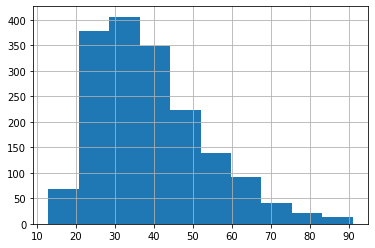

In [ ]:
def paso_a_int(x):
  try:
    return int(x)
  except:
    pass

pd.Series([paso_a_int(x) for x in ds['EDAD_ACUSADO/A AL MOMENTO DEL HECHO']]).hist()

##### Podemos ver que aunque los valores de esta variable se concentran entre 20 y 45 años, el dominio de la variable es bastante amplio. En base al análisis de este histograma y el conocimiento del dominio, proponemos transformar esta variable continua a una variable discreta con las siguientes categorías:

##### -s/d
##### -menos_de_18
##### -entre_18_30
##### -entre_30_40
##### -entre_40_50
##### -50_o_mas

In [ ]:
def nuevas_categorias_edad(x):
  """
  Esta función mapea valores a categorías. Puede tomar como input string casteables a int, o valores no casteables, que serán
  clasificados como 's/d'. Los valores serán agrupados según las siguientes categorías de edad:
  -s/d
 -menos_de_18
 -entre_18_30
 -entre_30_40
 -entre_40_50
 -50_o_mas

  Parámetros
  ----------
  x: str, int, float
    Para ser categorizado correctamente, el valor debe ser casteable a int, de lo contrario, la función lo categorizará como 's/d' 

  Salida
  ------
  str:
    Devuelve un string con la nueva categoría a la que fue mapeado el valor de entrada.

  """
  try:
    if int(x)<18:
      return 'menos_de_18'
    if int(x)<30:
      return 'entre_18_30'
    if int(x)<40:
      return 'entre_30_40'
    if int(x)<50:
      return 'entre_40_50'
    else:
      return '50_o_mas'
  except:
    return 's/d'

In [ ]:
###Genero nuevas categorías para la variable EDAD_ACUSADO/A AL MOMENTO DEL HECHO
vals = ds['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].apply(nuevas_categorias_edad)

In [ ]:
###Reviso los nuevos valores
vals.value_counts()

s/d            547
entre_18_30    501
entre_30_40    492
50_o_mas       371
entre_40_50    360
menos_de_18      5
Name: EDAD_ACUSADO/A AL MOMENTO DEL HECHO, dtype: int64

In [ ]:
###Reemplazo valores en la columna original
ds['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = vals

#### Análisis y transformaciónde la variable "LUGAR_DEL_HECHO\n"

In [ ]:
freq_cat(ds['LUGAR_DEL_HECHO\n'])

,% Acum
Categoría,
via_publica,49.384886
en_domicilio_laboral,67.530756
mediante_medios_tecnológicos,80.623902
en_domicilio_particular,88.971880
s/d,92.223199
puerta_de_domicilio_particular,93.760984
en_lugar_privado,95.254833
pasillo_de_domicilio,96.177504
en_una_institucion_educativa,96.792619


##### Vemos que existe cierta concentración de las observaciones en las primeras categorías de la variable. Re definiremos las categorías de esta variable en 6 nuevos niveles:

##### -via_publica
##### -en_domicilio_laboral
##### -mediante_medios_tecnológicos
##### -en_domicilio_particular
##### -s/d
##### -otros

In [ ]:
###Reemplazo las categorias
nuevas_categorias = ['via_publica', 'en_domicilio_laboral',  'mediante_medios_tecnológicos', 'en_domicilio_particular', 's/d']
ds['LUGAR_DEL_HECHO\n'] = ds['LUGAR_DEL_HECHO\n'].apply(lambda x: x if x in nuevas_categorias else 'otros')

In [ ]:
###Reviso las nuevas categorías
ds['LUGAR_DEL_HECHO\n'].value_counts()

via_publica                     1124
en_domicilio_laboral             413
mediante_medios_tecnológicos     298
en_domicilio_particular          190
otros                            177
s/d                               74
Name: LUGAR_DEL_HECHO\n, dtype: int64

#### Análisis y transformación de la variable TIPO_DE_RESOLUCION

In [ ]:
freq_cat(ds.TIPO_DE_RESOLUCION)

,% Acum
Categoría,
interlocutoria,65.070299
definitiva,100.000000


##### Mantenemos las categorías sin transformar

#### Análisis y transformación de la variable OBJETO_DE_LA_RESOLUCION 

In [ ]:
freq_cat(ds.OBJETO_DE_LA_RESOLUCION)

,% Acum
Categoría,
suspension_del_proceso_a_prueba,28.910369
medida_cautelar,41.608084
medida_probatoria,51.625659
cuestion_de_competencia,61.423550
juicio_oral,69.200351
juicio_abreviado,75.615114
ejecucion_de_la_pena,80.975395
admisibilidad_prueba,84.007030
nulidad,85.325132


##### Para esta variable vamos a mantener 7 categorías. Las nuevas variables serán:

##### - suspension_del_proceso_a_prueba
##### - cuestion_de_competencia
##### - medida_cautelar
##### - admisibilidad_prueba
##### - medida_probatoria
##### - juicio_abreviado
##### - otros


In [ ]:
### Reemplazo las categorias
nuevas_categorias = ['suspension_del_proceso_a_prueba', 'cuestion_de_competencia',  'medida_cautelar', 'admisibilidad_prueba','medida_probatoria', 'juicio_abreviado']
ds.OBJETO_DE_LA_RESOLUCION = ds.OBJETO_DE_LA_RESOLUCION.apply(lambda x: x if x in nuevas_categorias else 'otros')

In [ ]:
### Reviso la transformación
ds.OBJETO_DE_LA_RESOLUCION.value_counts()

otros                              663
suspension_del_proceso_a_prueba    658
medida_cautelar                    289
medida_probatoria                  228
cuestion_de_competencia            223
juicio_abreviado                   146
admisibilidad_prueba                69
Name: OBJETO_DE_LA_RESOLUCION, dtype: int64

#### Analisis y transformación de la variable 'DETALLE'

In [ ]:
freq_cat(ds.DETALLE)

,% Acum
Categoría,
extincion_accion_sobreseimiento,12.961336
admisibilidad,25.527241
secuestro,32.688928
incompetencia_territorial,36.599297
pena_de_multa_en_suspenso,40.465729
prorroga,44.024605
allanamiento,47.275923
pena_de_multa_efectivo_cumplimiento,50.000000
incompetencia_en_razon_de_materia,52.548330


##### Vemos que son muchas categorías, y existe una distribución relativamente uniforme de las observaciones, al menos entre las principales. Esto dificulta la reducción a un número aceptable de nuevas categorías. Por ello, y para evitar incorporar ruido excesivo a la salida, por el momento evitaremos trabajar con esta variable, y no la presentaremos al público.

In [ ]:
ds.drop(columns=['DETALLE'], inplace = True)

#### Análisis y transformación de la variable 'DECISION'

In [ ]:
ds.DECISION.value_counts()

hace_lugar       1983
no_hace_lugar     292
Name: DECISION, dtype: int64

##### Mantenemos las categorías como aparecen

##3.1.3 Evaluación de las transformaciones realizadas

##### En este punto probablemente nos estemos preguntando cuál es el incremento en la calidad de la información resultante como resultado de las transformaciones realizadas. Para responder este interrogante, podemos comparar la divergencia de KL y el error absoluto aplicando DP antes y después de las transformaciones propuestas.

##### Para facilitar la comparación, las variables continuas que refieren a la edad serán transformadas como se hizo durante el procesamiento anterior. Asimismo, las variables en las que habían categorías escritas en minúscula y mayúscula serán homogeneizadas como se hizo anteriormente.

##### Para aplicar DP utilizaremos un budegt fijo de 5 $\epsilon$, que se distribuirá proporcionalmente entre cada feature. Realizaremos 100 simulaciones, para llegar a resultados más robustos.

In [ ]:
###Carguemos nuevamente el dataset original
ds_original = pd.read_csv('/content/gdrive/MyDrive/dataset_gral.csv', index_col=0)

In [ ]:
### Elimino las columnas que refieren SOLO a causas de violencia de género
eliminar = ['MODALIDAD_DE_LA_VIOLENCIA','V_FISICA','NACIONALIDAD_DENUNCIANTE', 'EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO', \
            'FRECUENCIA_EPISODIOS', 'RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE','HIJOS_HIJAS_EN_COMUN', \
            'MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO']
ds_original.drop(columns=eliminar, inplace=True)

In [ ]:
###Genero nuevas categorías para la variable EDAD_ACUSADO/A AL MOMENTO DEL HECHO
ds_original['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = ds_original['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].apply(nuevas_categorias_edad)

In [ ]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    q= np.where(q == 0, 0.000000001, q)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
### Computo medidas de divergencia KL y error absoluto sobre el dataset original
budget = 5
epsilon = budget/len(ds_original.columns)###Distribuyo budget entre los features
divergencia_kl_igual_budget_prepro = []
error_absoluto_igual_budget_prepro = []

for i in range(0,100):
  div_kl_hist = []
  error_abs_hist = []

  for (columnName, columnData) in ds_original.iteritems():
    codes = pd.Categorical(columnData).codes ###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, epsilon=epsilon , delta=0, sens=len(ds_original.columns), bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())

  divergencia_kl_igual_budget_prepro.append(div_kl_hist)
  error_absoluto_igual_budget_prepro.append(error_abs_hist)
divergencia_kl_igual_budget_prepro = np.mean(divergencia_kl_igual_budget_prepro, axis=0)
error_absoluto_igual_budget_prepro = np.mean(error_absoluto_igual_budget_prepro, axis=0)

In [ ]:
### Computo medidas de divergencia KL y error absoluto sobre el dataset luego de las transformaciones aplicadas
budget = 5
epsilon = budget/len(ds.columns)###Distribuyo budget entre los features
divergencia_kl_igual_budget = []
error_absoluto_igual_budget = []
for i in range(0,100):
  div_kl_hist = []
  error_abs_hist = []

  for (columnName, columnData) in ds.iteritems():
    codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, epsilon=epsilon ,delta=0, sens=len(ds.columns), bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())

  divergencia_kl_igual_budget.append(div_kl_hist)
  error_absoluto_igual_budget.append(error_abs_hist)
divergencia_kl_igual_budget = np.mean(divergencia_kl_igual_budget, axis=0)
error_absoluto_igual_budget = np.mean(error_absoluto_igual_budget, axis=0)

In [ ]:
###Analizamos la salida
print('Divergencia KL promedio entre los features antes y después de DP - Antes de hacer ingeniería de atributos: ' + str(np.mean(divergencia_kl_igual_budget_prepro)))
print('Divergencia KL promedio entre los features antes y después de DP - Después de hacer ingeniería de atributos: ' + str(np.mean(divergencia_kl_igual_budget)))
print('')
print('Error absoluto promedio entre los features antes y después de DP - Antes de hacer ingeniería de atributos: ' + str(np.mean(error_absoluto_igual_budget_prepro)))
print('Error absoluto promedio entre los features antes y después de DP - Después de hacer ingeniería de atributos: ' + str(np.mean(error_absoluto_igual_budget)))


Divergencia KL promedio entre los features antes y después de DP - Antes de hacer ingeniería de atributos: 1.0236401427420934
Divergencia KL promedio entre los features antes y después de DP - Después de hacer ingeniería de atributos: 0.0032472219553438034

Error absoluto promedio entre los features antes y después de DP - Antes de hacer ingeniería de atributos: 0.3738060297593231
Error absoluto promedio entre los features antes y después de DP - Después de hacer ingeniería de atributos: 0.018079527767535814


Text(0.5, 0.98, 'Métricas de error promedio del mecanismo de DP  antes y después de aplicar ingeniería de atributos sobre el dataset')

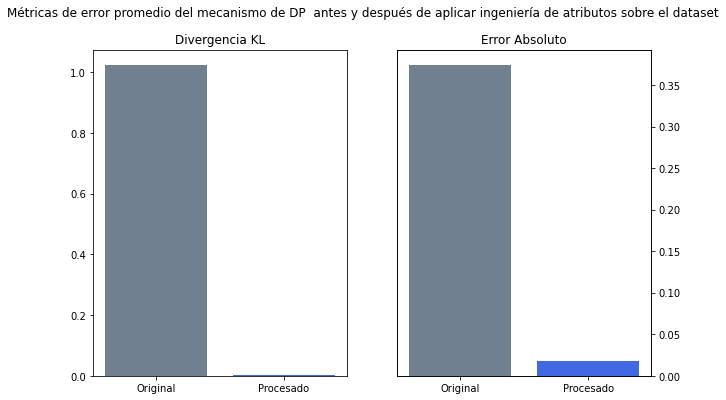

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))


ax[0].bar(x=[1,2], height=[np.mean(divergencia_kl_igual_budget_prepro), np.mean(divergencia_kl_igual_budget)], color = ['slategray', 'royalblue'])
twinx = ax[1].twinx()
twinx.bar(x=[1,2], height=[np.mean(error_absoluto_igual_budget_prepro), np.mean(error_absoluto_igual_budget)], color = ['slategray', 'royalblue'])

ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['Original', 'Procesado'])
ax[0].set_title('Divergencia KL')

twinx.set_xticks([1,2])
twinx.set_xticklabels(['Original', 'Procesado'])

ax[1].set_yticks([])
twinx.set_title('Error Absoluto')

fig.suptitle('Métricas de error promedio del mecanismo de DP  antes y después de aplicar ingeniería de atributos sobre el dataset')

Lo que demuestra este análisis es que el error introducido por el mecanismo de DP luego de aplicada la ingeniería de atributos, es muy bajo, prácticamente de 0. La divergencia KL pasó de 1,02 a 0, mientras que el error absoluto disminuyó de 0,37 a 0,02. Si bien esto da cuenta de la conveniencia del reordenamiento de la cardinalidad de las variables, consideramos que refleja principalmente el descarte de atributos, que alcanzó a 5 de las 12 columnas originales. Si bien existe un trade off entre el descarte de variables “problemáticas” y la calidad global de la salida de la información, en este caso es evidente que la información original era muy deficiente y el descarte necesario. Ello puede observarse en la magnitud del error absoluto de la salida del mecanismos de DP sobre el dataset original, que es superior al 35%. Publicar un conjunto de datos con un error absoluto del 35% (con una divergencia KL también alta), no tiene sentido desde el uso posterior que se pueda realizar de esta información, ya que la distribución original de la misma ha sido bastante desnaturalizada. En este escenario, es preferible publicar menos información pero de mayor calidad, a intentar publicar toda la información disponible a riesgo de que sea de poca calidad y usabilidad.

En el notebook que sigue veremos si podemos seguir mejorando estas métricas de error.

In [ ]:
###Guardamos el csv procesado
ds.to_csv('/content/gdrive/MyDrive/dataset_gral_pro.csv')

## 3.1.4 Ahora sí! Hemos terminado el análisis y transformación de las variables. Seguiremos con la optimización de los mecanismos de DP en el notebook 3.2